<a href="https://colab.research.google.com/github/fle1scha/DL4NTP/blob/main/DL4NTP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import tensorflow and numpy
import tensorflow as tf
import keras
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
#Import keras models
from random import random
from numpy import array
from numpy import cumsum

from keras.layers import Bidirectional
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.preprocessing.sequence import TimeseriesGenerator
print(keras.__version__)

2.5.0


In [ ]:
#Import scikit modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [ ]:
#Import any other libraries needed
import math
import os
from datetime import datetime, date

# Read in Data

1. Mount Google Drive file system

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


2. Read in SANReN sample data.

In [ ]:
with open('/content/gdrive/My Drive/SANReN.txt') as f:
  SANReN = f.readlines()
  
#Iterate through first 10 rows to ensure data has been read correctly. 
'''for i in range(10):
  print(SANReN[i])'''

'for i in range(10):\n  print(SANReN[i])'

# ***Data Preprocessing***

3. Clean dataframe headers

In [ ]:
headings_line = SANReN[0].split()
#Merge 'Src', 'IP', and 'Addr:Port' 
headings_line[4:7] = [''.join(headings_line[4:7])]
#Merge 'Dst', 'IP', and 'Addr:Port' 
headings_line[5:8] = [''.join(headings_line[5:8])]
#Remove 'Flags', 'Tos', and 'Flows'.
headings_line = headings_line[0:6] + headings_line[8:13]


4. Clean time-series data points

In [ ]:
framedata = []
for i in range(1, len(SANReN)):
  data_line = SANReN[i].split()

  if (data_line[11] == "M" and data_line[14] == 'M'): #Bytes and BPS in megabytes
    #print("1 and 2") 
    
    data_line = data_line[0:5] + data_line[6:7] + data_line[9:11] + data_line[12:14] + data_line[15:16]
    data_line[7] = float(data_line[7])*1000000 #Change M bytes into byte measurement. 
    data_line[9] = float(data_line[9])*1000000 #Change M bytes into byte measurement. 
   
 
  elif (data_line[13] == 'M'): #BPS measured in megabytes
    #print("2")
    data_line = data_line[0:5] + data_line[6:7] + data_line[9:13] + data_line[14:15]
    data_line[9] = float(data_line[9])*1000000 #Change M bytes into byte measurement. 
  
  elif data_line[11] == 'M': #Bytes measured in megabytes
    #print("1")
    
    data_line = data_line[0:5] + data_line[6:7] + data_line[9:11] + data_line[12:15]
    data_line[7] = float(data_line[7])*1000000 #Change M bytes into byte measurement. 
    
  else: #No megabyte metrics
    #print("0")
    data_line = data_line[0:5] + data_line[6:7] + data_line[9:14]
   

  data_line  = np.asarray(data_line) 
  framedata.append(data_line)
  

5. Convert numpy array into pandas dataframe and add additional columns.
  - Day: gives the day of the week as an integer. Monday is 0 and Sunday is 6.

In [ ]:
df = pd.DataFrame(np.array(framedata), columns=headings_line)
#df['Date'] = pd.to_datetime(df['Date'])

print(df) # Print data just to check it is formatted correct

          Date    first-seen Duration Proto  ...       Bytes   pps         bps   Bpp
0   2020-07-04  20:10:06.480    1.223   TCP  ...      234000  3679   1500000.0    52
1   2020-07-04  20:09:01.555   78.205   TCP  ...  46500000.0   396   4800000.0  1500
2   2020-07-04  20:10:01.690    5.307   TCP  ...       40000   188       60297    40
3   2020-07-04  20:09:23.019   43.982   TCP  ...   3000000.0    45      545677  1500
4   2020-07-04  20:10:07.007    0.000   TCP  ...      750000     0           0  1500
..         ...           ...      ...   ...  ...         ...   ...         ...   ...
78  2020-07-04  20:10:07.454    0.000   TCP  ...      750000     0           0  1500
79  2020-07-04  20:10:07.458    0.000   TCP  ...      728000     0           0  1456
80  2020-07-04  20:10:07.463    0.000   TCP  ...       20000     0           0    40
81  2020-07-04  20:10:07.464    4.021   TCP  ...   5200000.0   870  10400000.0  1500
82  2020-07-04  20:10:07.467    0.000   TCP  ...       26000     

In [ ]:
#Examining column headings
#print(df.columns)
#Examining all unique IP addresses in sample.
#print(pd.unique(df["SrcIPAddr:Port"]))

#Define all data types correctly. 
df = df.astype({"Date": np.datetime64})
df["Day"] = df['Date'].dt.dayofweek
df = df.astype({'first-seen': np.datetime64})
df = df.astype({'Duration': np.float64})
df = df.astype({"SrcIPAddr:Port": str})
df = df.astype({"DstIPAddr:Port": str})
df = df.astype({"Packets": np.int64})
df = df.astype({"Bytes": np.float64})
df = df.astype({"pps": np.float64})
df = df.astype({"bps": np.float64})
df = df.astype({"Bpp": np.float64})


In [ ]:
#display(df.dtypes)
df = (df.drop(['Date', 'first-seen', 'Proto', 'SrcIPAddr:Port', 'DstIPAddr:Port'], axis = 1))
print(df.shape)

(83, 7)


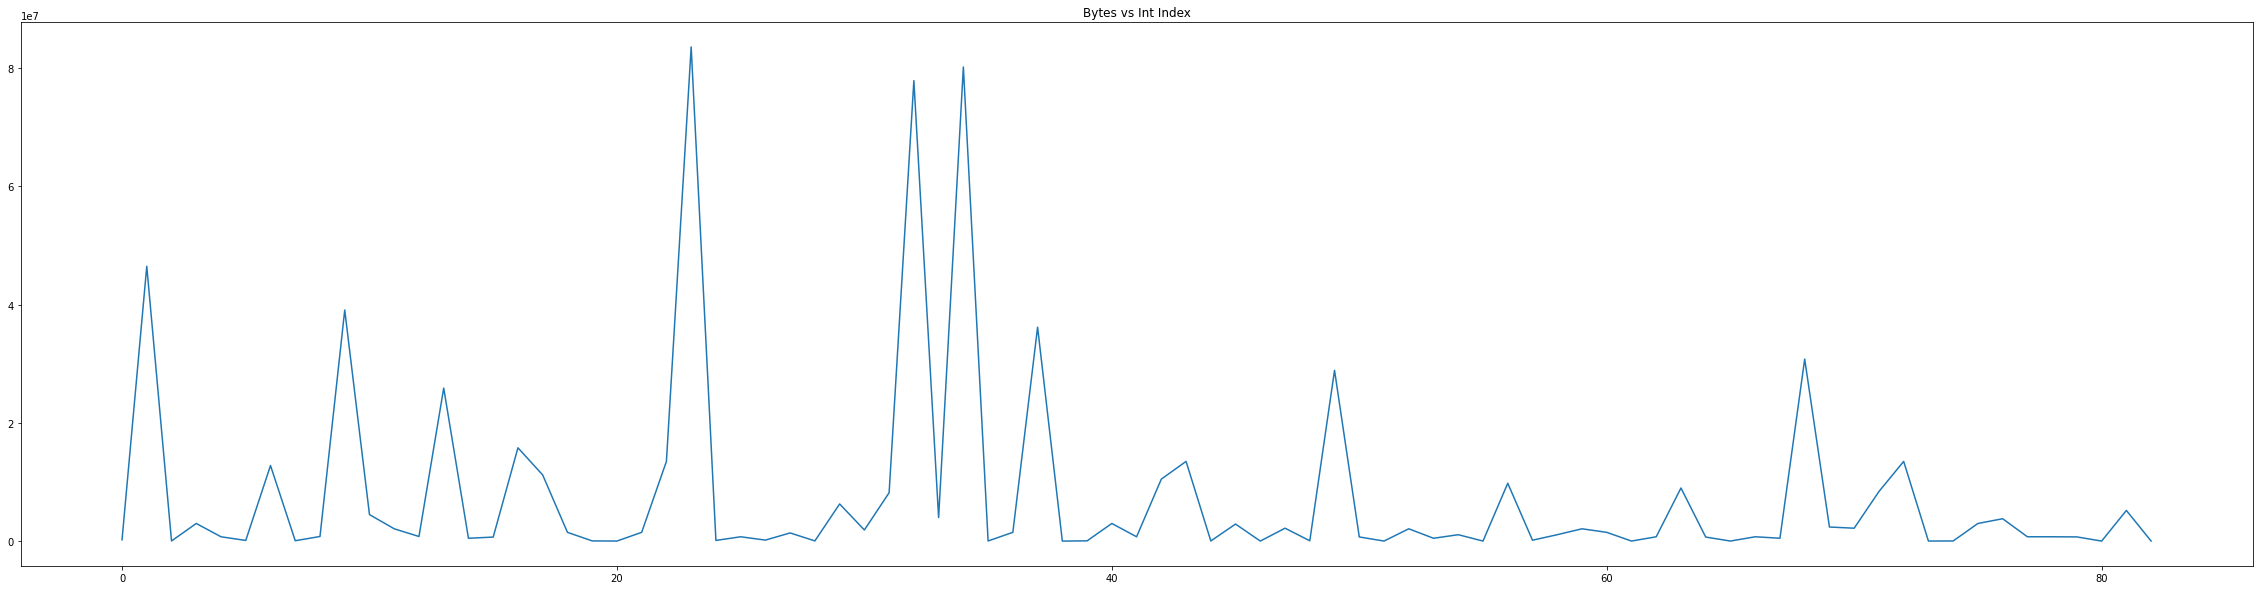

In [ ]:
#A plot of Bytes vs time 
plt.figure(figsize=(40,10))
plt.title("Bytes vs Int Index")
plt.plot(range(len(df)), df['Bytes'])

6. Split data into both training and test set. Use 80/20 split. 
   Decide later whether validation set or whether cross validation applied




In [ ]:
test_size = int(len(df) * 0.2) # the test data will be 20% (0.2) of the entire data
train = df.iloc[:-test_size,:].copy() 
# the copy() here is important, it will prevent us from getting: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame. Try using .loc[row_index,col_indexer] = value instead
test = df.iloc[-test_size:,:].copy()


X_train = train.drop('Bytes',axis=1).copy()
y_train = train[['Bytes']].copy() # the double brakets here are to keep the y in a dataframe format, otherwise it will be pandas Series
print(X_train.shape, y_train.shape)



In [ ]:
#Visualise split in sample
plt.figure(figsize=(40,10))
plt.title("Split of Test and Train Set using Bytes as target variable")
plt.plot(train.index,train['Bytes'],label='Training set');
plt.plot(test.index,test['Bytes'],label='Test set')
plt.legend();

In [ ]:
Xscaler = MinMaxScaler(feature_range=(0, 1)) # scale so that all the X data will range from 0 to 1
Xscaler.fit(X_train)
scaled_X_train = Xscaler.transform(X_train)
print(X_train.shape)
Yscaler = MinMaxScaler(feature_range=(0, 1))
Yscaler.fit(y_train)
scaled_y_train = Yscaler.transform(y_train)
print(scaled_y_train.shape)
scaled_y_train = scaled_y_train.reshape(-1) # remove the second dimention from y so the shape changes from (n,1) to (n,)
print(scaled_y_train.shape)

scaled_y_train = np.insert(scaled_y_train, 0, 0)
scaled_y_train = np.delete(scaled_y_train, -1)

In [ ]:
n_input = 25 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= X_train.shape[1] # how many predictors/Xs/features we have to predict y
b_size = 32 # Number of timeseries samples in each batch
train_generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_input, batch_size=b_size)

print(train_generator[0][0].shape)

(32, 25, 6)


# Simple LSTM Implementation

7. Defining the Keras model configuaration for Simple LSTM



In [ ]:
simple_LSTM_model = Sequential()
simple_LSTM_model.add(LSTM(150, activation='sigmoid', input_shape=(n_input, n_features)))
simple_LSTM_model.add(Dense(1))
simple_LSTM_model.compile(optimizer='adam', loss='mse')
#Loss measured in mean squarred error terms, the optimzer adam refers to the learning rate change, which is measured by the exponentially decaying average of past gradients
simple_LSTM_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 150)               94200     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 151       
Total params: 94,351
Trainable params: 94,351
Non-trainable params: 0
_________________________________________________________________


8. Fit the data to the model and train. Generate a summary of the model and show training results

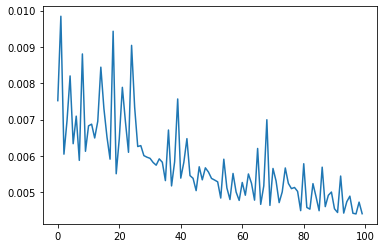

In [59]:
simple_LSTM_model.fit(generator, epochs=100, verbose = 0) # Fit the features excluding target, and predict the target value
# verbose of 0 hides the training, 2 shows the full log
loss_per_epoch = simple_LSTM_model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch);

9. TESTING

In [ ]:
X_test = test.drop('Bytes',axis=1).copy()
y_test = test[['Bytes']].copy() # the double brakets here are to keep the y in a dataframe format, otherwise it will be pandas Series
print(X_test.shape, y_test.shape)

In [ ]:
Xscaler = MinMaxScaler(feature_range=(0, 1)) # scale so that all the X data will range from 0 to 1
Xscaler.fit(X_test)
scaled_X_test = Xscaler.transform(X_test)
print(X_test.shape)
Yscaler = MinMaxScaler(feature_range=(0, 1))
Yscaler.fit(y_test)
scaled_y_test = Yscaler.transform(y_test)
print(scaled_y_test.shape)
scaled_y_test = scaled_y_test.reshape(-1) # remove the second dimention from y so the shape changes from (n,1) to (n,)
print(scaled_y_test.shape)

scaled_y_test = np.insert(scaled_y_test, 0, 0)
scaled_y_test = np.delete(scaled_y_test, -1)

In [68]:
n_features= X_train.shape[1] # how many predictors/Xs/features we have to predict y
test_generator = TimeseriesGenerator(scaled_X_test, scaled_y_test, length=10)

print(test_generator[0][0].shape)

(6, 10, 6)


In [70]:
simple_LSTM_predictions = simple_LSTM_model.predict(scaled_X_test, verbose=2)

ValueError: ignored

9. Calculate prediction metrics

In [ ]:
simple_LSTM_training_mse = np.square(np.subtract(training_set[0], simple_LSTM_training_predictions[:,0])) #We want to calculate the difference between our predicted and actual values
simple_LSTM_test_mse = np.square(np.subtract(test_set[0], simple_LSTM_test_predictions[:,0]))
print('Train Score: %.2f MSE' % (simple_LSTM_training_mse))
simple_LSTM_testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f MSE' % (simple_LSTM_test_mse))

# Bidirectional LSTM Implementation

10. Defining the Keras model configuaration for Bidirectional LSTM



In [ ]:
# Bidirectional LSTM supported in Keras using a layer wrapper 
# Common approach is to use concatenate, providing 2x outputs to next layer
# Takes the first LSTM layer as an argument
bidirectional_lstm_model = Sequential()
bidirectional_lstm_model.add(Bidirectional(LSTM(20, return_sequences=True)))
bidirectional_lstm_model.add(TimeDistributed(Dense(1, activation='sigmoid')))
bidirectional_lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])